In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In our network analysis, we will mainly focus on the Music Groups Network (MG-N) to narrow the scope and enable a more in-depth exploration. This network was selected because it exhibits simple yet interesting properties. The musicians network has an interpretation problem as nodes with the highest centrality often correspond to musicians in large symphony orchestras and are thereby hard to interpret if a high degree musician is associated with mulitiple music groups or is in large music group. Futhermore, very few musicans (of famous bands even) does not have a wikipedia article. Thereby it is natural to focus on music grous, that also will be the focus of text analysis.

In [37]:
with open("data/groups_graph.pkl", "rb") as f:
    G = pickle.load(f)

We calculate the probability (p) average degree (k) of the network 
ref[Section 3.2, equation (3.2) in Network Science, Albert-Laszlo Barabasi]

In [38]:
N = G.number_of_nodes()
L = G.number_of_edges()

p = L / ((N*(N-1))/2)  # for undirected graphs, we divide by 2

k = p*(G.number_of_nodes() - 1)

print(f"Size of network: {N}")
print(f"Probability: {p}")
print(f"Average degree: {k}")

Size of network: 814
Probability: 0.0016772895001677288
Average degree: 1.3636363636363635


The average degreee is 20, so on average a musician is sharing associated music groups with 20 other musicians.
___


Now, we write a function to generate a Random Network that mirrors the Danish Musicians Network in terms of node count, using your calculated p. We generate the random network by linking nodes in every possible pair with probability.

In [4]:
def random_network(N,p):
    
    #Start with N isolated nodes.
    R = nx.Graph()
    R.add_nodes_from(range(N))

    #Select a node pair and generate a random number between 0 and 1
    for u in range(N):
        for v in range(u+1,N):
            if np.random.rand() < p: #If the number exceeds p:
                R.add_edge(u,v) #connect the selected node pair with a link, otherwise leave them disconnected.
    return R

F = random_network(N,p)

In [ ]:
# Function to visualize the graph F and G in one figure
def plot_2graphs(G, F):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    plt.title("Random Network")
    plt.axis('off')
    pos = nx.spring_layout(F)
    nx.draw(F, pos, node_size=10, node_color='blue', alpha=0.5, width=0.2)
    plt.subplot(1, 2, 2)
    plt.title("Original Network")
    plt.axis('off')
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=10, node_color='red', alpha=0.5, width=0.2)
    plt.show()

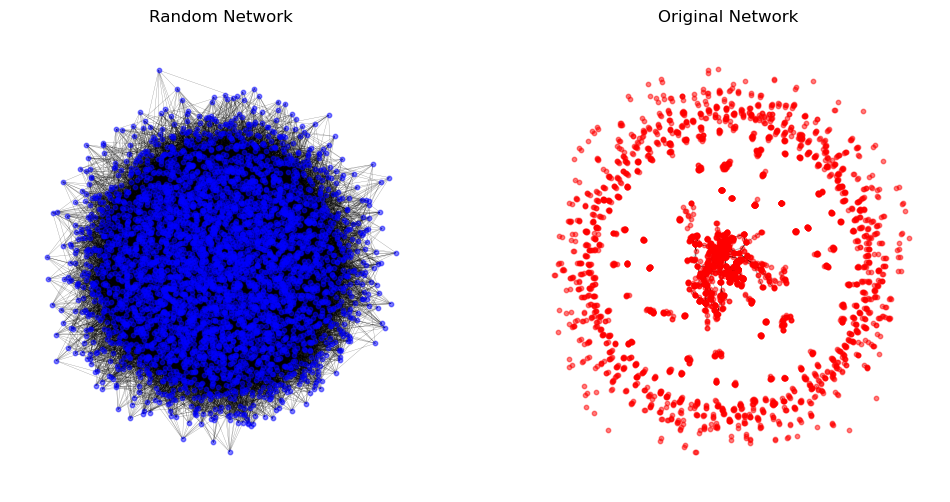

In [6]:
plot_2graphs(G, F)

In [12]:
G_components = nx.connected_components(G)
G_largest_component = max(G_components, key=len)
G_giant = G.subgraph(G_largest_component)


F_components = nx.connected_components(F)
F_largest_component = max(F_components, key=len)
F_giant = F.subgraph(F_largest_component)

# calculate size of the largest component
G_largest_size = len(G_largest_component)
F_largest_size = len(F_largest_component)
print(f"Size of the largest component in G: {G_largest_size}")
print(f"Size of the largest component in F: {F_largest_size}")

Size of the largest component in G: 1718
Size of the largest component in F: 4151


We see a big diffence between the networks. The random network is fully connected and in the super-critical regime as k = 20 >> 1. In contrast, the musicians network is disconected, this makes sense because many musicians are solo artist. However it seems to have a very connected centre. To investigate this further we will try to look only at the giant component.

In [ ]:
# To do a fair comparison to a random network, we re-define the random network to mirror the giant.

N_giant = G_giant.number_of_nodes()
p_giant = G_giant.number_of_edges() / ((N_giant*(N_giant-1))/2)  # for undirected graphs, we divide by 2

print(f"Size of giant: {N_giant}")
print(f"Average degree: {p_giant*(N_giant - 1)}")

F_giant = random_network(N_giant,p_giant)

Size of giant: 1718
Average degree: 41.43422584400466


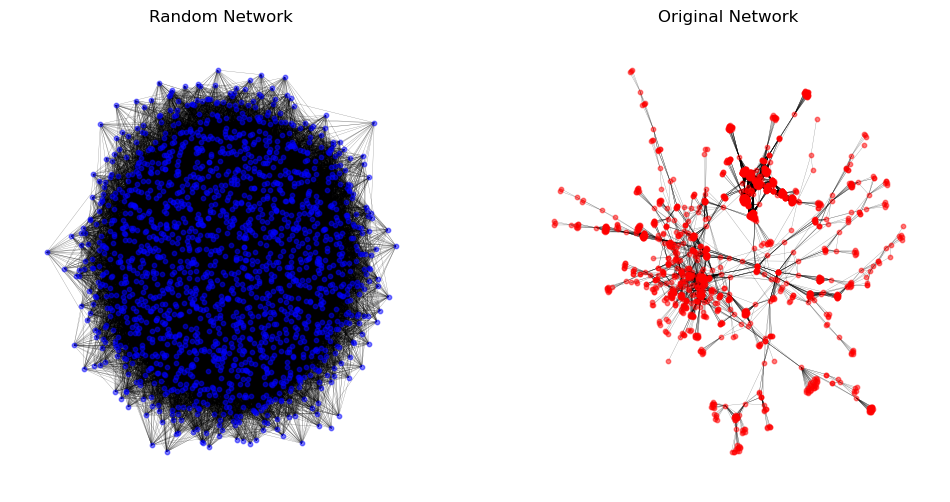

In [9]:
plot_2graphs(G_giant, F_giant)

Looking at the plot, the musicians network seems far from random. This encourage us to investigate possible communities, degree distribution and small world property.

Note: We will from now on only look at the giant component to focus on band-playing musicians. Additionally, this removes most naming-errors in the data and is computational easier to run.

### Small-world property

In [13]:
# Calculate the average shortest path length within the giant:
shortest_G = nx.average_shortest_path_length(G_giant,None)
shortest_F = nx.average_shortest_path_length(F_giant,None)

print(f"Average shortest path length for the giant in the random network: {shortest_F}")
print(f"Average shortest path lenght for the giant in the musicians network: {shortest_G}")

Average shortest path length for the giant in the random network: 3.043298958300076
Average shortest path lenght for the giant in the musicians network: 6.012429969970906


In [15]:
clustering_G = nx.average_clustering(G_giant)
clustering_F = nx.average_clustering(F_giant)

print(f"Clustering coefficient for the giant in the random network: {clustering_F}")
print(f"Clustering coefficient for the giant in CSS-network: {clustering_G}")

Clustering coefficient for the giant in the random network: 0.004723238138718647
Clustering coefficient for the giant in CSS-network: 0.9273498479059259


The musicans network has an average shortest path of 6, which means that, on average, there is a maximum of around six links between two scientists. This is approximately double the average shortest path in the random network, suggesting that the musicans network may not have small-world properties as $L_{real}$ ≈ $L_{random}$ doesn't hold completely. However, the clustering coefficients calculated below indicate significantly higher clustering than the random network, which is a key characteristic of small-world networks. This suggests that it might possess weak small-world characteristics, aligning more with other social networks than with random structures.

This is a very interesting insight. Muscians tend to cluster strongly but also isolate them selves in more distinct communities. This is comparred to computational social scientists from our earlier assignments,where there $L_{real} = 5.13$ ≈ $L_{random} = 6.15$.

### Degree distribution

In [30]:
def scatter_dist(G, F):
    def get_deg_dist(graph):
        degree_dict = dict(graph.degree())
        return np.unique(list(degree_dict.values()), return_counts=True)

    # Get degree distributions
    degs_G, counts_G = get_deg_dist(G)
    degs_F, counts_F = get_deg_dist(F)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(degs_G, counts_G, s=20, alpha=0.7, label='Original Network', color='blue')
    plt.scatter(degs_F, counts_F, s=20, alpha=0.3, label='Random Network', color='red')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree", fontsize=12)
    plt.ylabel("Degree Count", fontsize=12)
    plt.title("Degree Distribution Comparison (Log-Log)", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.3)
    plt.show()

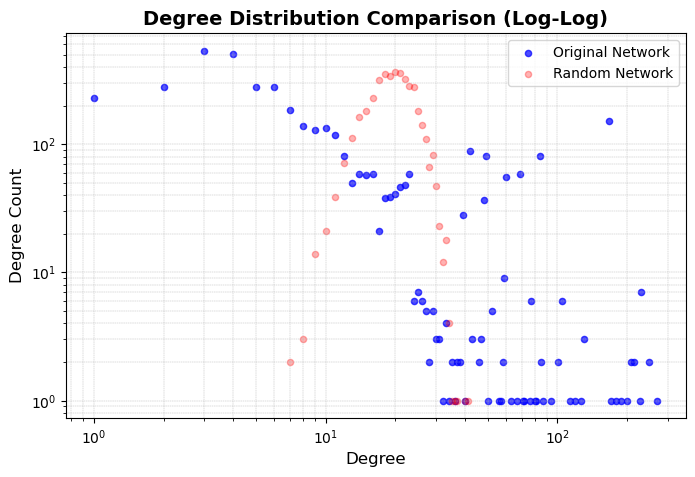

In [32]:
scatter_dist(G, F)

In [35]:
# Compute Eigen centrality for the giant component of the musicians network
eigen_centrality_G = nx.eigenvector_centrality(G_giant)

# Compute Eigen centrality for the giant component of the random network
eigen_centrality_F = nx.eigenvector_centrality(F_giant)

# Print the top 5 nodes with the highest Eigen centrality in each network
top_5_G = sorted(eigen_centrality_G.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_F = sorted(eigen_centrality_F.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 nodes by Eigen centrality in the musicians network:")
for node, centrality in top_5_G:
    print(f"Node: {node}, Centrality: {centrality:.4f}")


Top 5 nodes by Eigen centrality in the musicians network:
Node: Anna Zelianodjevo, Centrality: 0.0789
Node: Helle Hanskov, Centrality: 0.0789
Node: Gunnar Lychou, Centrality: 0.0789
Node: Astrid Christensen, Centrality: 0.0789
Node: Dmitri Golovanov, Centrality: 0.0789
